In [64]:
# fetch MNIST dataset
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [65]:
X, y = mnist['data'], mnist['target']

In [66]:
X.shape

(70000, 784)

In [67]:
y.shape

(70000,)

So there are 70,000 images, each with 784 features (i.e. 28x28 pixels).

Let's look at one digit:

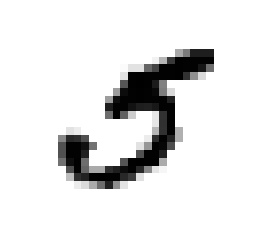

In [68]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [69]:
#checking label:
y[36000]

5.0

In [70]:
# create training & test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [71]:
#shuffle training set so that all CV folds are similar:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a binary classifier
...to detect whether the number is a 5.

In [72]:
# create target vectors:
y_train_5 = (y_train == 5.0)
y_test_5 = (y_test == 5.0)

In [73]:
np.unique(y_train_5)

array([False,  True], dtype=bool)

In [74]:
# let's start with SGD
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

#test on the digit we picked out earlier:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## Implementing cross validation

In [75]:
# Implementing ourselves for greater control:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct / len(y_pred))

0.92935
0.9623
0.9589


In [76]:
# Implementing off the shelf:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([ 0.92935,  0.9623 ,  0.9589 ])

## Confusion matrix

In [77]:
# first get set of predictions:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

# now create confusion matrix:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52851,  1728],
       [ 1261,  4160]])

In [78]:
# for comparison, this is the result we would get if the classifier was perfect:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [79]:
# calculate precision and recall:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.70652173913043481

Meaning when the predictor claims a number is a 5, it is correct 87% of the time

In [80]:
recall_score(y_train_5, y_train_pred)

0.76738609112709832

Meaning the predictor 'catches' 76% of the 5s

In [81]:
# calculate F1 score:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.73569723229286421

### Investigating SGD Classifier threshold

In [82]:
# let's look at threshold for 'some digit'
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 112835.20518798])

In [83]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True], dtype=bool)

The SGDClassifier uses a threshold of 0, so it predicts 'some_digit' is a 5.

Let's see what would happen if the threshold were raised to 100,000:

In [84]:
threshold = 100000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True], dtype=bool)

This shows that raising the threshold reduces the recall.

How do we decide what threshold is best to use? Let's look at the scores for all of the predictions:

In [85]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = 'decision_function')

In [86]:
y_scores

array([-596490.27548259,  107229.79277645, -616862.46638901, ...,
       -698692.81559297, -801841.08996249, -635132.99688739])

In [87]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

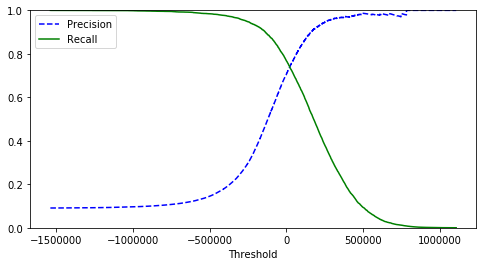

In [88]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')
    plt.ylim([0, 1])

plt.figure(figsize = (8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [89]:
## if wanted to increase precision , you can effectively raise the threshold by running this:
y_train_pred_90 = (y_scores > 80000)

# check precision:
precision_score(y_train_5, y_train_pred_90)

0.82014719411223547

In [90]:
# and recall:
recall_score(y_train_5, y_train_pred_90)

0.65781221176904625

## ROC Curve

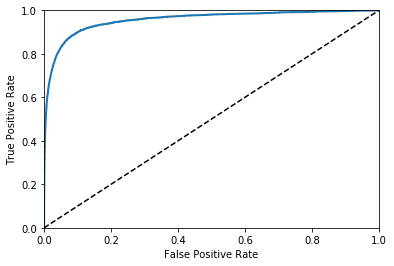

In [91]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

Can see that the higher the recall (TPR), the more false positives there are.

The dotted line represents a purely random classifier.

Can calculate the area under the curve:

In [92]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.95606137907410393

# Random Forest Classifier

In [93]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

# use the positive class's probability as the score:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

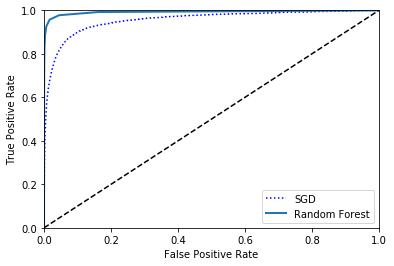

In [94]:
# compare ROC curves
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'lower right')
plt.show()

In [95]:
roc_auc_score(y_train_5, y_scores_forest)

0.99257182544473443

# Multiclass classification
### SGD

In [96]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [97]:
# in this case the classifier is wrong. Now to have a look at the decision functions for better understanding:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-208505.13411997, -401290.15278231, -303158.21362412,
        -247163.38499127, -407440.21502631,  112835.20518798,
        -648544.86964046, -238657.63466313, -545151.71735029,
        -706329.07783924]])

In [98]:
np.argmax(some_digit_scores)

5

In [99]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [100]:
sgd_clf.classes_[0]

0.0

### Random Forest Classifier

In [101]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [102]:
# in this case the classifier is correct. Now to have a look at the probabilities:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0.1,  0.7,  0. ,  0. ,  0. ,  0. ]])

Classifier is 80% certain number is a 5, with 10% chance each assigned to it being a 1 (strange) or 3 (more understandable).

Evaluating SGD classifier accuracy:

In [103]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([ 0.85862827,  0.87924396,  0.85442816])

Scaling inputs  and evaluating impact:

In [104]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([ 0.90946811,  0.90909545,  0.90993649])

Much higher accuracy! D:

## Error analysis

In [105]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5730,    3,   20,    9,   11,   47,   52,    7,   40,    4],
       [   1, 6474,   48,   26,    6,   43,    6,   11,  116,   11],
       [  52,   37, 5339,  105,   88,   29,   82,   56,  155,   15],
       [  46,   39,  138, 5338,    6,  240,   35,   57,  136,   96],
       [  21,   25,   33,    7, 5379,    7,   48,   29,   79,  214],
       [  70,   44,   33,  179,   82, 4614,  105,   26,  174,   94],
       [  40,   26,   51,    1,   41,   85, 5623,    6,   45,    0],
       [  24,   20,   72,   28,   61,   12,    6, 5792,   16,  234],
       [  54,  151,   74,  168,   14,  160,   54,   26, 5009,  141],
       [  44,   32,   25,   89,  172,   33,    2,  202,   78, 5272]])

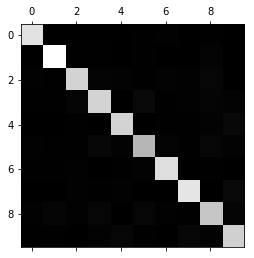

In [106]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

Focus plot on errors.
1. Divide each value in confusion matrix by number of images in corresponding class
2. Fill diagonal with zeros to keep only errors

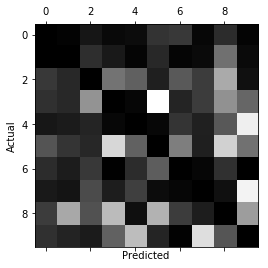

In [107]:
# step 1:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

# step 2:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Insights:
* Columns for 8 and 9 are quite bright, so many images get misclassified as 8s and 9s
* Rows for 8 and 9 are also bright, so they are often confused for other digits
* Row for 1 is dark, so it often gets classified correctly.
* Matrix is not symmetrical e.g. more 5s are missclassified as 8s than the other way round

In [116]:
# plot examples of 3s and 5s
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

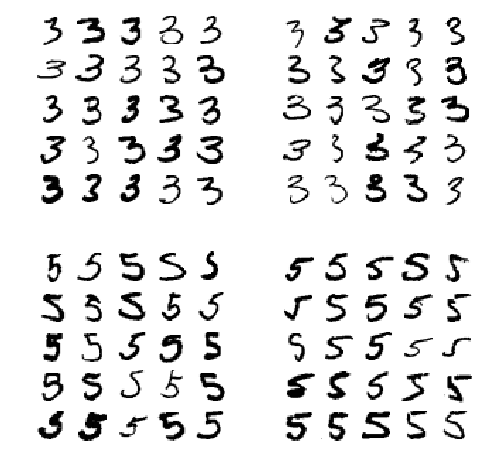

In [118]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize = (8,8))

plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()